#  Movie Sentiment Classifier using fast text embedding(LSTM) vs CNN model  

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import codecs
from tqdm import tqdm

from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import gensim
import time
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf

from tensorflow.keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, MaxPooling1D, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/arditoibryan/Projects/master/20200602_Twitter_Sentiment_Analysis/movie_review.csv')

In [3]:
df.head()

,fold_id,cv_tag,html_id,sent_id,text,tag
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos


In [4]:
df.shape

(64720, 6)

In [5]:
df['tag'].value_counts()

pos    32937
neg    31783
Name: tag, dtype: int64

Tags are the target in our dataset where 'pos' stands for positive and 'neg' is negative. We drop the columns which are not required.

In [6]:
df = df.drop(['fold_id', 'cv_tag', 'html_id', 'sent_id'], axis=1)

In [7]:
df.head()

,text,tag
0,films adapted from comic books have had plenty...,pos
1,"for starters , it was created by alan moore ( ...",pos
2,to say moore and campbell thoroughly researche...,pos
3,"the book ( or "" graphic novel , "" if you will ...",pos
4,"in other words , don't dismiss this film becau...",pos


In [8]:
df.columns = ['tweets', 'sentiment']

In [9]:
df.head()

,tweets,sentiment
0,films adapted from comic books have had plenty...,pos
1,"for starters , it was created by alan moore ( ...",pos
2,to say moore and campbell thoroughly researche...,pos
3,"the book ( or "" graphic novel , "" if you will ...",pos
4,"in other words , don't dismiss this film becau...",pos


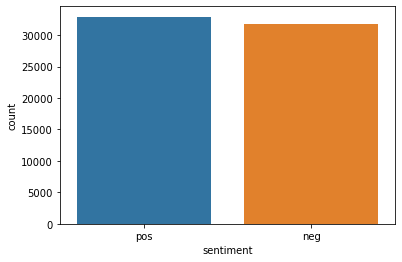

In [10]:
sns.countplot(x="sentiment", data=df);

In [11]:
# change sentiment value to either 0 or 1
df['sentiment'] = [1 if s=='pos' else 0 for s in df['sentiment']]

In [12]:
df.head()

,tweets,sentiment
0,films adapted from comic books have had plenty...,1
1,"for starters , it was created by alan moore ( ...",1
2,to say moore and campbell thoroughly researche...,1
3,"the book ( or "" graphic novel , "" if you will ...",1
4,"in other words , don't dismiss this film becau...",1


In [13]:
df_preprocess = df.copy()

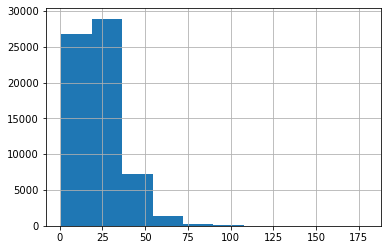

In [14]:
# get length of all the messages in the data set
seq_len = [len(i.split()) for i in df['tweets']]

pd.Series(seq_len).hist();

In [15]:
tweets = df_preprocess.tweets
tweets.head()

0    films adapted from comic books have had plenty...
1    for starters , it was created by alan moore ( ...
2    to say moore and campbell thoroughly researche...
3    the book ( or " graphic novel , " if you will ...
4    in other words , don't dismiss this film becau...
Name: tweets, dtype: object

In [16]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [17]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [18]:
df_preprocess.tweets = df_preprocess.tweets.apply(lambda x: preprocess(x))

In [19]:
df_preprocess= df_preprocess[['tweets', 'sentiment']]

In [20]:
df_preprocess.head()

,tweets,sentiment
0,films adapted comic books plenty success wheth...,1
1,starters created alan moore eddie campbell bro...,1
2,say moore campbell thoroughly researched subje...,1
3,book graphic novel 500 pages long includes nea...,1
4,words dismiss film source,1


In [21]:
df_preprocess['sentiment'].value_counts()

1    32937
0    31783
Name: sentiment, dtype: int64

In [22]:
df_preprocess= df_preprocess.rename(columns={'tweets': 'tweet', 'sentiment': 'sentiment'})
df_preprocess.head()

,tweet,sentiment
0,films adapted comic books plenty success wheth...,1
1,starters created alan moore eddie campbell bro...,1
2,say moore campbell thoroughly researched subje...,1
3,book graphic novel 500 pages long includes nea...,1
4,words dismiss film source,1


The dataset is balanced

In [23]:
# Utilize the keras tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_preprocess.tweet)

word_index = tokenizer.word_index
vocabulary_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocabulary_size)

Vocabulary Size : 39245


### Fast Text Embedding & Utilize Pretrained models

In [24]:
FASTEXT_EMB = 'wiki-news-300d-1M.vec'
EMBEDDING_DIM = 300

In [25]:
embeddings_index = {}
f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

999995it [01:52, 8862.53it/s]

found 999995 word vectors


In [26]:
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [27]:
encoded_text=tokenizer.texts_to_sequences(df_preprocess.tweet)

In [28]:
max_sequence_length = 60
X=pad_sequences(encoded_text, maxlen=max_sequence_length, padding='post')
y=df_preprocess['sentiment']

In [29]:
batch_size = 512
epoch = 15

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Train Data size:", len(X_train))
print("Test Data size", len(X_test))

Train Data size: 48540
Test Data size 16180


In [31]:
embedding_matrix.shape

(39245, 300)

In [32]:
embedding_layer = tf.keras.layers.Embedding(vocabulary_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=max_sequence_length,
                                          trainable=False)

We also utilize early stopping.

In [33]:
es=EarlyStopping(monitor='val_loss', min_delta=0, mode='min', verbose=1, patience=10)

reduce_lr = ReduceLROnPlateau(factor=0.1, min_delta=0, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

### Create a Pretrained bidirectional LSTM model

For creating the model, we use

- Embedding Layer - Generates Embedding Vector for each input sequence.

- Conv1D Layer - It is used to convolve the data into smaller feature vectors.

- LSTM - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which further along the text carry contextual meaning rather than just neighbouring words as in case of RNN.

- Dense - Fully Connected Layers for classification

In [34]:
inputs = Input(shape=(max_sequence_length,), dtype='int32')
x = embedding_layer(inputs)
x = SpatialDropout1D(0.2)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

2022-05-17 20:53:12.860770: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy',metrics=['accuracy'])

#### Plot the model

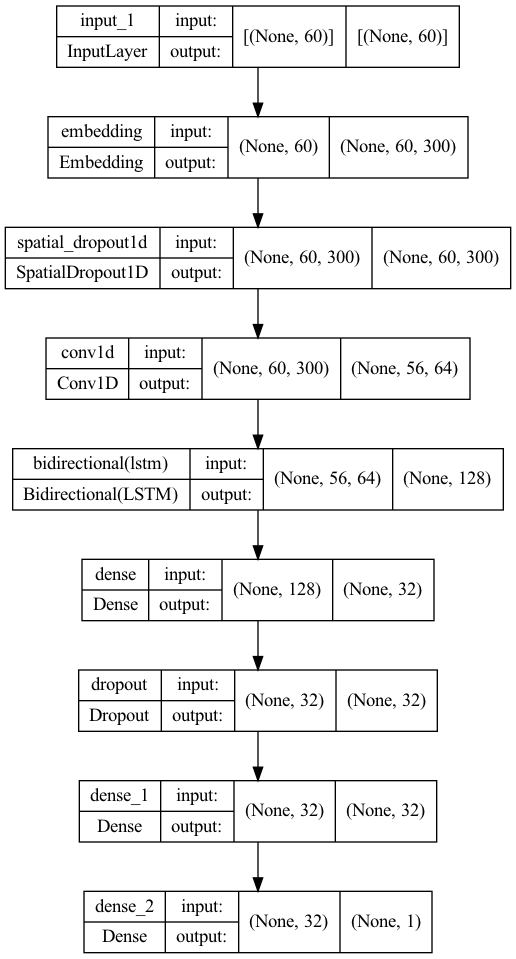

In [36]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [37]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch,
                    validation_data=(X_test, y_test), callbacks= [es, reduce_lr])

Epoch 1/15
95/95 [==============================] - 88s 865ms/step - loss: 0.6695 - accuracy: 0.5830 - val_loss: 0.6481 - val_accuracy: 0.6209 - lr: 0.0010
Epoch 2/15
95/95 [==============================] - 81s 851ms/step - loss: 0.6478 - accuracy: 0.6238 - val_loss: 0.6375 - val_accuracy: 0.6334 - lr: 0.0010
Epoch 3/15
95/95 [==============================] - 81s 854ms/step - loss: 0.6376 - accuracy: 0.6341 - val_loss: 0.6356 - val_accuracy: 0.6363 - lr: 0.0010
Epoch 4/15
95/95 [==============================] - 80s 844ms/step - loss: 0.6285 - accuracy: 0.6437 - val_loss: 0.6330 - val_accuracy: 0.6397 - lr: 0.0010
Epoch 5/15
95/95 [==============================] - 81s 855ms/step - loss: 0.6101 - accuracy: 0.6685 - val_loss: 0.6277 - val_accuracy: 0.6467 - lr: 0.0010
Epoch 6/15
95/95 [==============================] - 82s 859ms/step - loss: 0.5899 - accuracy: 0.6855 - val_loss: 0.6258 - val_accuracy: 0.6486 - lr: 0.0010
Epoch 7/15
95/95 [==============================] - 80s 847ms/st

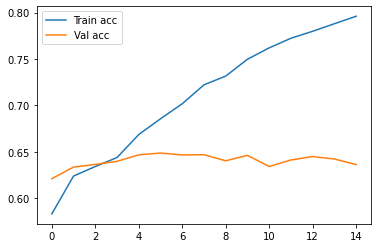

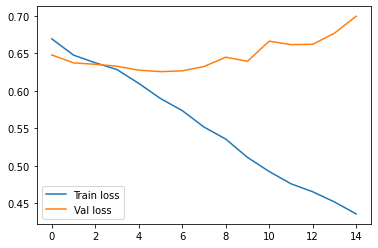

In [38]:
#Plot the leaning curves
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

In [39]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

506/506 [==============================] - 9s 17ms/step - loss: 0.6997 - accuracy: 0.6362
Accuracy: 63.62%


In [40]:
# Predicting on the Test dataset.
y_pred = model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>0.5, 1, 0)

# Printing out the Evaluation metrics. 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(y_pred,y_test)
print(cm)

# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

[[5863 3764]
 [2123 4430]]
              precision    recall  f1-score   support

           0       0.61      0.73      0.67      7986
           1       0.68      0.54      0.60      8194

    accuracy                           0.64     16180
   macro avg       0.64      0.64      0.63     16180
weighted avg       0.64      0.64      0.63     16180



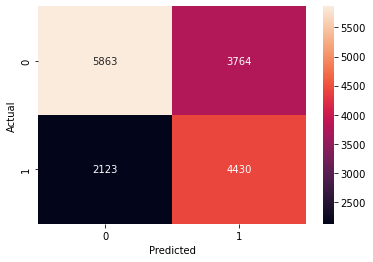

In [41]:
import matplotlib.pyplot as plt

# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [42]:
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"

In [43]:
def decode_sentiment(score):
    return NEGATIVE if score < 0.5 else POSITIVE

In [44]:
def predict(text):
    print(text)
    start_at = time.time()
    # Tokenize text
    X_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_sequence_length)
    # Predict
    score = model.predict([X_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [45]:
predict("The movie was aweful")

The movie was aweful


{'label': 'NEGATIVE',
 'score': 0.3214765191078186,
 'elapsed_time': 0.5000817775726318}

In [46]:
predict("The film was creative and surprising")

The film was creative and surprising


{'label': 'NEGATIVE',
 'score': 0.416933536529541,
 'elapsed_time': 0.07064485549926758}

### CNN model from scratch

In [47]:
embedding_dim=50

model2=Sequential()
model2.add(Embedding(vocabulary_size, embedding_dim, input_length=max_sequence_length))
model2.add(Conv1D(64, 7, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(Dropout(0.5))

model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.5))
model2.add(GlobalMaxPooling1D())
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

In [48]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
history=model2.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), callbacks=[es, reduce_lr])

Epoch 1/15
1517/1517 [==============================] - 57s 37ms/step - loss: 0.6838 - accuracy: 0.5496 - val_loss: 0.6672 - val_accuracy: 0.6204 - lr: 0.0010
Epoch 2/15
1517/1517 [==============================] - 57s 38ms/step - loss: 0.6130 - accuracy: 0.6718 - val_loss: 0.6233 - val_accuracy: 0.6579 - lr: 0.0010
Epoch 3/15
1517/1517 [==============================] - 57s 37ms/step - loss: 0.5270 - accuracy: 0.7392 - val_loss: 0.5973 - val_accuracy: 0.6744 - lr: 0.0010
Epoch 4/15
1517/1517 [==============================] - 56s 37ms/step - loss: 0.4515 - accuracy: 0.7846 - val_loss: 0.5986 - val_accuracy: 0.6718 - lr: 0.0010
Epoch 5/15
1517/1517 [==============================] - 57s 38ms/step - loss: 0.3845 - accuracy: 0.8197 - val_loss: 0.6370 - val_accuracy: 0.6661 - lr: 0.0010
Epoch 6/15
1517/1517 [==============================] - 57s 37ms/step - loss: 0.3301 - accuracy: 0.8455 - val_loss: 0.7117 - val_accuracy: 0.6651 - lr: 0.0010
Epoch 7/15
1517/1517 [========================

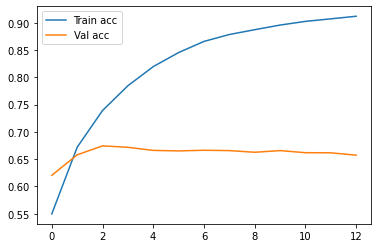

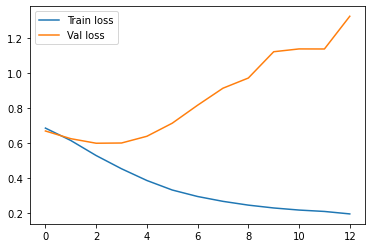

In [50]:
#Plot the leaning curves
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

In [51]:
scores = model2.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

506/506 [==============================] - 2s 3ms/step - loss: 1.3226 - accuracy: 0.6573
Accuracy: 65.73%


In [52]:
def predict(text):
    print(text)
    start_at = time.time()
    # Tokenize text
    X_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_sequence_length)
    # Predict
    score = model2.predict([X_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [53]:
predict("That movie was absolutely awful")

That movie was absolutely awful


{'label': 'NEGATIVE',
 'score': 0.024712592363357544,
 'elapsed_time': 0.17551684379577637}

In [54]:
predict("The film was creative and surprising")

The film was creative and surprising


{'label': 'NEGATIVE',
 'score': 0.3554215729236603,
 'elapsed_time': 0.07648396492004395}